In [7]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [11]:
%matplotlib notebook

# Exploring the various components of the FFT2 function

In [4]:
from basictools import fft2

In [84]:
reload(fft2)

<module 'basictools.fft2' from '/Users/nielscautaerts/Documents/PythonProjects/TEMMETA/basictools/fft2.py'>

In [9]:
hrtem = Image.open("./examples/1l.tif")

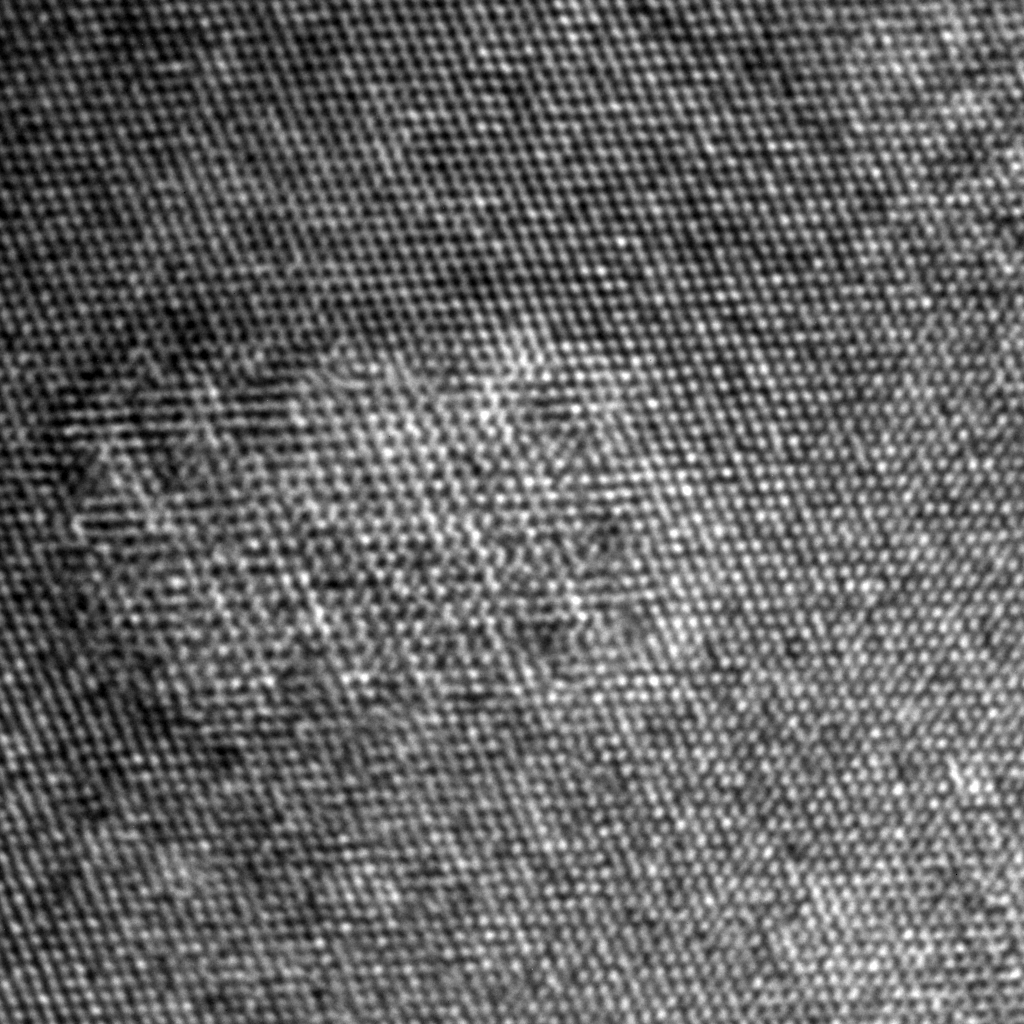

In [13]:
hrtem

In [14]:
hrtemdata = np.array(hrtem)

In [32]:
fft_hrtem = np.fft.fft2(hrtemdata)
fft2_shift = np.fft.fftshift(fft_hrtem)

In [36]:
fft2_db = 20 * np.log10(abs(fft2_shift))

<IPython.core.display.Javascript object>


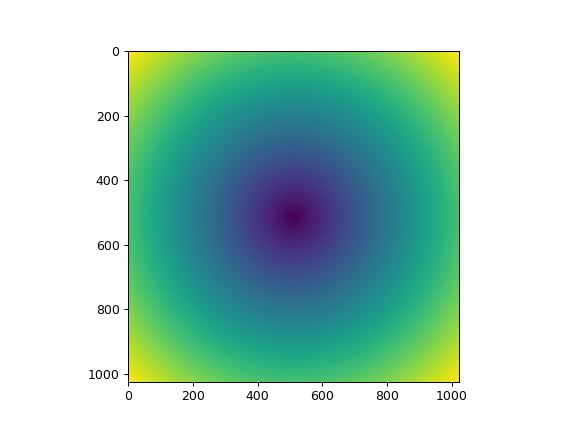

In [47]:
fig, ax = plt.subplots(1)
plt.imshow(fft2_db, cmap = "Greys_r")

In [44]:
fft2_blur = fft2.gausfilter(fft2_db, ks=7, sig=4)

<IPython.core.display.Javascript object>


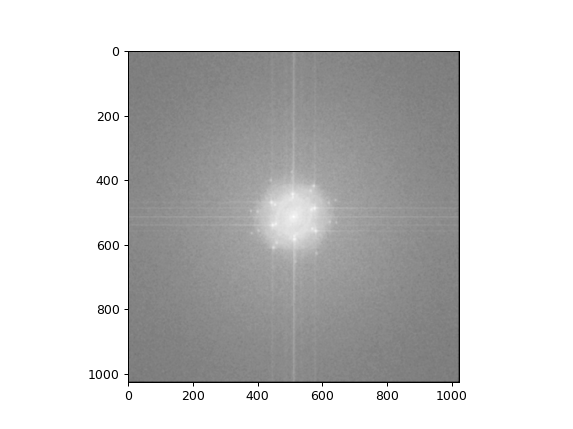

In [46]:
fig, ax = plt.subplots(1)
ax.imshow(fft2_blur, cmap = "Greys_r")

In [57]:
(Nx, Ny) = fft2_db.shape
x = np.arange(-Nx / 2, Nx / 2, 1)
y = np.arange(-Ny / 2, Ny / 2, 1)
xv, yv = np.meshgrid(x, y)
mask_radius = np.sqrt(np.square(xv) + np.square(yv))
mask = mask_radius > 20

#fft2_masked = fft2_blur * mask
#fft2_masked_max = max(fft2_masked)
#fft2_blur = fft2_blur / fft2_masked_max

In [62]:
fft2_masked = fft2_blur * mask

In [68]:
fft2_masked_max = np.max(fft2_masked)

<IPython.core.display.Javascript object>


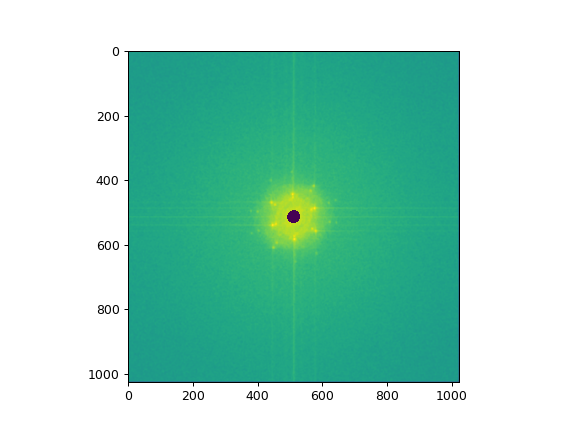

In [64]:
plt.imshow(fft2_masked)

In [69]:
fft2_blur = fft2_blur / fft2_masked_max

In [70]:
fft2_blur[fft2_blur > 1] = 1

<IPython.core.display.Javascript object>


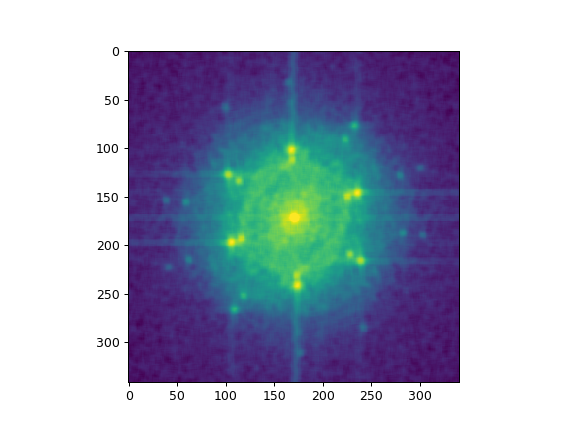

In [71]:
plt.imshow(fft2_blur)

In [73]:
fft2_blur = fft2_blur[Nx//3:Nx*2//3,
                Ny//3:Ny*2//3]

In [85]:
fft_test = fft2.fft2_image(hrtem)

<IPython.core.display.Javascript object>


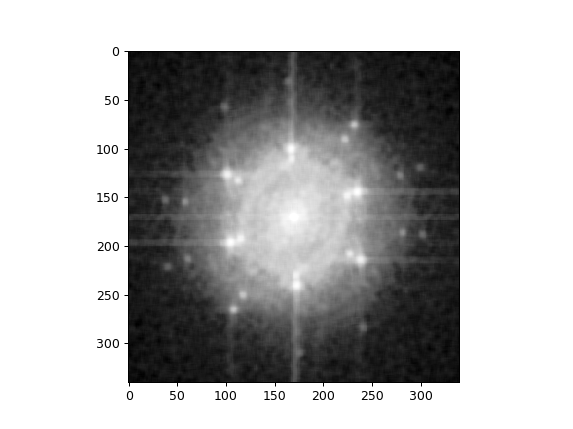

In [87]:
plt.imshow(fft_test, cmap = "Greys_r")

# Butterworth filter - should be applied to STEM images

In [155]:
def bwf_lin(x, order):
    return 1 - 1 / np.sqrt(1 + np.power(x, order) / np.power(.5, 16))

<IPython.core.display.Javascript object>


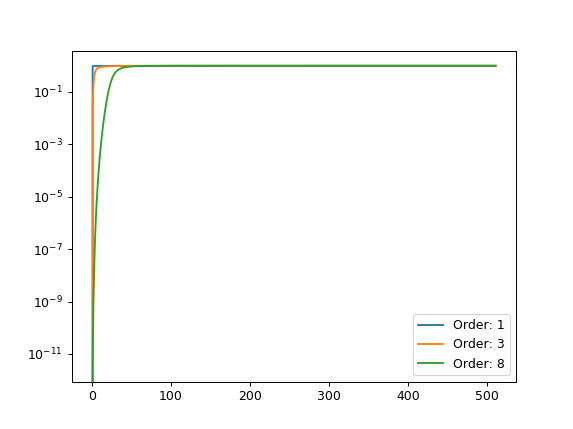

In [179]:
fig, ax = plt.subplots(1)
x = np.arange(0, 512)
orders = [1, 3, 8]

for i in orders:
    ax.plot(x, bwf_lin(x/100, i), label = f"Order: {i}")
    
ax.set_yscale("log")
    
ax.legend()

In [143]:
inc = 3
order = 10
psize = 1/inc

Nx, Ny = np.array(hrtem).shape

psize = 1 / inc
lsize = np.array([Nx, Ny]) * psize

qx = np.roll(np.arange(-Nx / 2, Nx / 2) / lsize[0],
             np.rint(-Nx / 2).astype(int, casting='unsafe'),
             axis=0)

qy = np.roll(np.arange(-Ny / 2, Ny / 2) / lsize[1],
             np.rint(-Ny / 2).astype(int, casting='unsafe'),
             axis=0)

# Apply low pass Butterworth filter
qxa, qya = np.meshgrid(qx, qy, sparse=True)
q2 = np.square(qxa) + np.square(qya)
wfilt = bwf_lin(q2, order)

In [144]:
print(wfilt.max())
print(wfilt.min())

0.9999978831140239
0.0


<IPython.core.display.Javascript object>


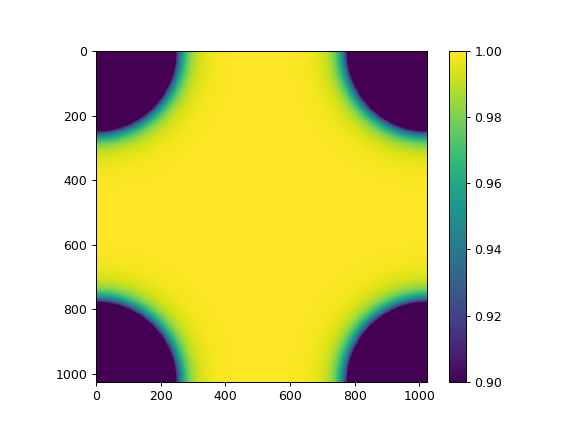

In [145]:
fig, ax = plt.subplots(1)
colplot = ax.imshow(wfilt, vmin=0.9, vmax=1)
fig.colorbar(colplot, ax = ax)
#ax.axis("off")

In [91]:
from basictools import butterworthFilter as bwf

In [93]:
reload(bwf)

<module 'basictools.butterworthFilter' from '/Users/nielscautaerts/Documents/PythonProjects/TEMMETA/basictools/butterworthFilter.py'>

In [171]:
im_bw = bwf.bwfilter(hrtem, 100, 8)

<IPython.core.display.Javascript object>


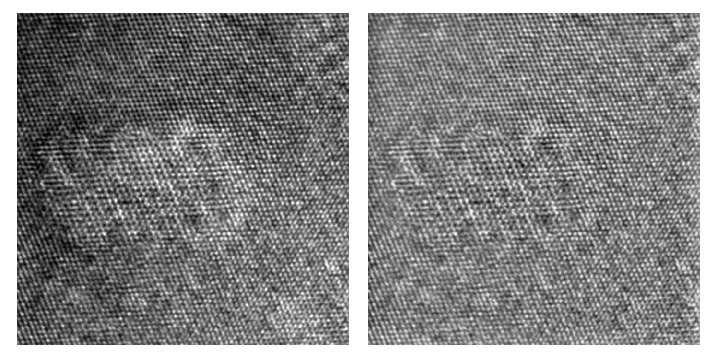

In [175]:
subfigs = [1, 2]
factor = 4

fig, axes = plt.subplots(subfigs[0], subfigs[1], figsize = (subfigs[1]*factor, subfigs[0]*factor))

axes[0].imshow(hrtem)
axes[1].imshow(im_bw, cmap = "Greys_r")

for i in axes:
    i.axis("off")
    
fig.tight_layout()

In [173]:
fft_bw = fft2.fft2_image(im_bw)

<IPython.core.display.Javascript object>


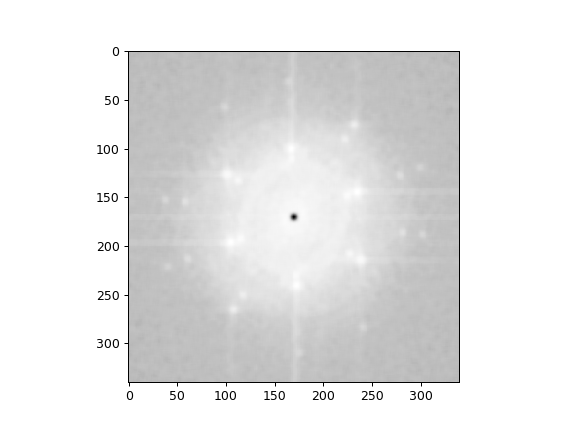

In [180]:
fig, ax = plt.subplots()
ax.imshow(fft_bw, cmap = "Greys_r")

# Peak finding

In [181]:
import cv2

In [183]:
from basictools import fitLatticePeaks as flp

<IPython.core.display.Javascript object>


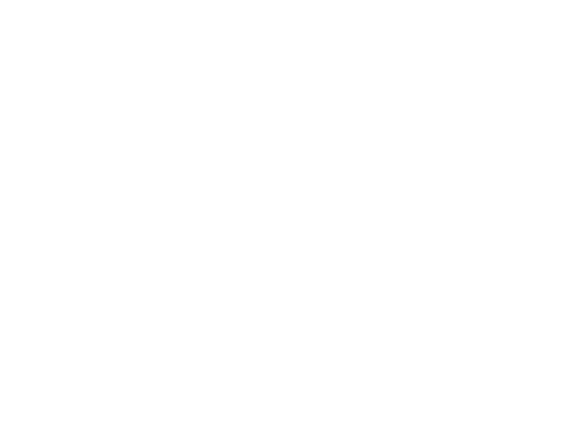

In [185]:
pks = flp.fitLatPeaks(hrtem)

In [186]:
from basictools import plotImagePeaks as pipks

In [189]:
reload(pipks)

<module 'basictools.plotImagePeaks' from '/Users/nielscautaerts/Documents/PythonProjects/TEMMETA/basictools/plotImagePeaks.py'>

<IPython.core.display.Javascript object>


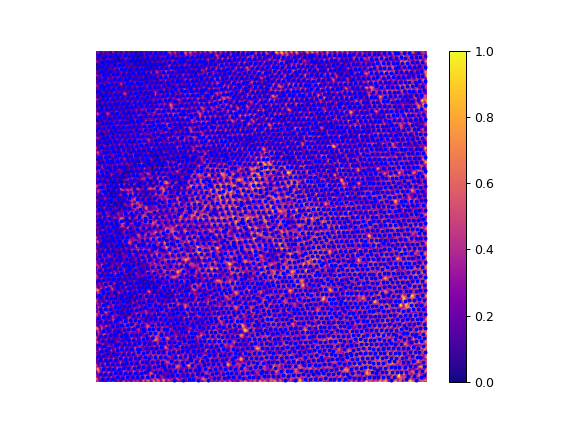

In [191]:
fig, ax = plt.subplots(1)
pipks.plotImagePeaks(hrtem, pks, ax = ax)

In [192]:
pks.shape

(4173, 3)

## sub parts of the function

In [246]:
image = np.array(hrtem)

In [251]:
bwf_args=(100, 8)
gauss_args=(7, 2) 
min_dist=10
min_int=0.2 
bound=5

# Normalize image
image = np.array(image)
image = np.squeeze(image)  # remove single dimensional axes
image = cv2.normalize(image, None, alpha=0, beta=1,
                      norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Determine image properties
# shape no. rows (Nx) x no. columns (Ny) x no. channels (Nz)
(Nx, Ny) = image.shape

# Apply Butterworth filter
image_filt = bwf.bwfilter(image, bwf_args[0], bwf_args[1])

# Apply Gaussian filter
k_size = gauss_args[0]
sigma = gauss_args[1]
image_filt = cv2.GaussianBlur(image_filt, (k_size, k_size), sigma)

# Normalize image
image_filt = cv2.normalize(image_filt, None, alpha=0, beta=1,
                           norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Determine lattice peaks with indices x_p, y_p
# cut off border of 1 pixel around
image_mid = image_filt[1:-1, 1:-1]
# move window around and check in which pixels mid remains highest
peaks = np.logical_and.reduce((image_mid > image_filt[0:-2, 0:-2],
                               image_mid > image_filt[1:-1, 0:-2],
                               image_mid > image_filt[2:, 0:-2],
                               image_mid > image_filt[0:-2, 1:-1],
                               image_mid > image_filt[2:, 1:-1],
                               image_mid > image_filt[0:-2, 2:],
                               image_mid > image_filt[1:-1, 2:],
                               image_mid > image_filt[2:, 2:]))

# get x and y coordinates where peaks is nonzero
(x_p, y_p) = np.nonzero(peaks*1)
num_peaks = int(np.size(x_p))

# reshape to column vector, add 1 to account for crop window
x_p = x_p.reshape(num_peaks, 1)
x_p += 1
y_p = y_p.reshape(num_peaks, 1)
y_p += 1
# find the intensity associated with the peak
I_p = image[x_p, y_p]

# make an array [x, y, intensity]
peaks = np.hstack((x_p, y_p, I_p))
# sort the peaks by intensity
peaks = peaks[np.argsort(peaks[:, 2])]

# Remove peaks too close together
del_peak = np.ones(num_peaks, dtype=bool)
for a0 in range(0, num_peaks - 1, 1):
    d2 = (x_p[a0] - x_p[a0 + 1:]) ** 2 + (y_p[a0] - y_p[a0 + 1:]) ** 2

    if np.min(d2) < (min_dist ** 2):
        del_peak[a0] = False

peaks = peaks[del_peak, :]

# Remove low intensity peaks
min_peaks = peaks[:, 2] > min_int
peaks = peaks[min_peaks, :]

# Remove peaks too close to image boundaries
del_bound = np.logical_and.reduce(
    (peaks[:, 0] > bound, peaks[:, 0] < Nx-bound,
     peaks[:, 1] > bound, peaks[:, 1] < Ny-bound))
peaks = peaks[del_bound, :]
peaks_Nx, peaks_Ny = np.shape(peaks)
num_peaks = peaks_Nx

<IPython.core.display.Javascript object>


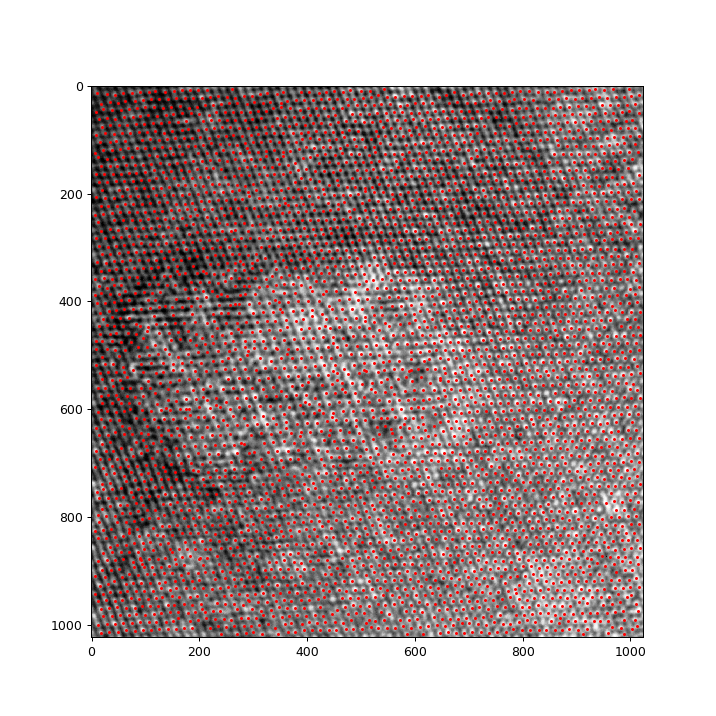

In [261]:
fig, ax = plt.subplots(1, figsize = (8,8))
ax.set_aspect("equal")
ax.imshow(image, cmap = "Greys_r")
ax.scatter(peaks[:,1], peaks[:,0], s = 2, c = "r")

In [197]:
image = cv2.normalize(image, None, alpha=0, beta=1,
                          norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
image_filt = bwf.bwfilter(image, 100, 8)
k_size = 7
sigma = 2
image_filt = cv2.GaussianBlur(image_filt, (k_size, k_size), sigma)
image_filt = cv2.normalize(image_filt, None, alpha=0, beta=1,
                               norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

<IPython.core.display.Javascript object>


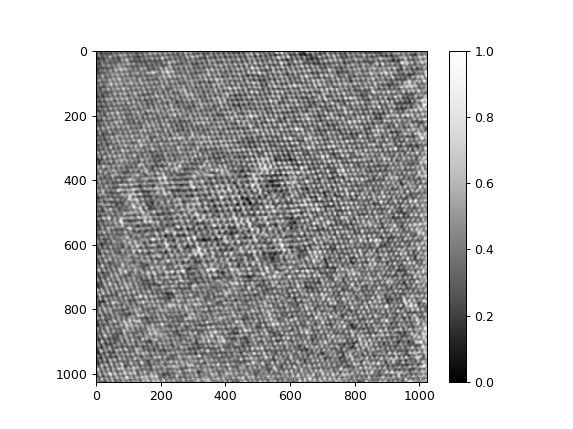

In [201]:
fig, ax = plt.subplots(1)
im = ax.imshow(image_filt, cmap = "Greys_r")
fig.colorbar(im, ax = ax)

In [202]:
# Determine lattice peaks with indices x_p, y_p
image_mid = image_filt[1:-1, 1:-1] #cut
peaks = np.logical_and.reduce((image_mid > image_filt[0:-2, 0:-2],
                               image_mid > image_filt[1:-1, 0:-2],
                               image_mid > image_filt[2:, 0:-2],
                               image_mid > image_filt[0:-2, 1:-1],
                               image_mid > image_filt[2:, 1:-1],
                               image_mid > image_filt[0:-2, 2:],
                               image_mid > image_filt[1:-1, 2:],
                               image_mid > image_filt[2:, 2:]))

In [204]:
example = image_mid > image_filt[0:-2, 0:-2]

<IPython.core.display.Javascript object>


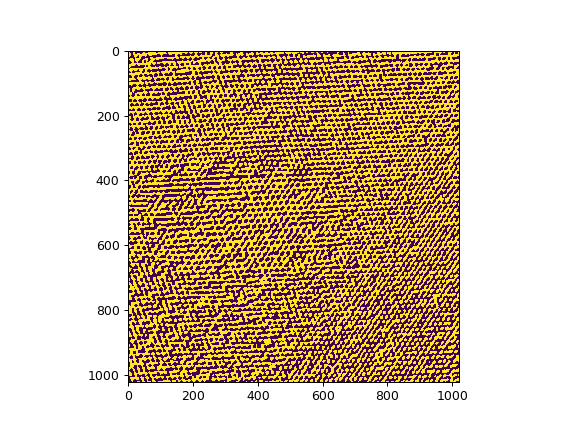

In [208]:
fig, ax = plt.subplots(1)
ax.imshow(example*1)

<IPython.core.display.Javascript object>


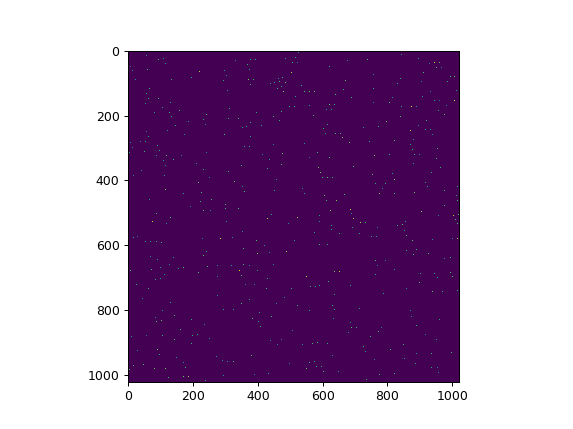

In [212]:
fig, ax = plt.subplots(1)
ax.imshow(peaks*image_mid)

In [231]:
(x_p, y_p) = np.nonzero(peaks*1)

In [220]:
x_p.shape

(4321,)

In [232]:
num_peaks = int(np.size(x_p))
x_p = x_p.reshape(num_peaks, 1)
x_p += 1
y_p = y_p.reshape(num_peaks, 1)
y_p += 1
I_p = image[x_p, y_p]

In [233]:
peaks = np.hstack((x_p, y_p, I_p))

In [234]:
peaks.shape

(4321, 3)

In [235]:
peaks

array([[1.00000000e+00, 6.90000000e+01, 1.76470593e-01],
       [1.00000000e+00, 5.88000000e+02, 6.27451003e-01],
       [2.00000000e+00, 6.20000000e+02, 7.64705956e-01],
       ...,
       [1.02000000e+03, 1.92000000e+02, 6.19607866e-01],
       [1.02000000e+03, 6.31000000e+02, 8.00000072e-01],
       [1.02200000e+03, 9.40000000e+02, 6.39215708e-01]])

In [236]:
from scipy.spatial import distance_matrix

In [239]:
data = peaks[:, :2]

In [240]:
distance_matrix(data, data)

array([[   0.        ,  519.        ,  551.00090744, ..., 1026.3966095 ,
        1163.70314084, 1342.04396351],
       [ 519.        ,    0.        ,   32.01562119, ..., 1093.24151037,
        1019.90685849, 1079.97453674],
       [ 551.00090744,   32.01562119,    0.        , ..., 1104.31336132,
        1018.05942852, 1069.01824119],
       ...,
       [1026.3966095 , 1093.24151037, 1104.31336132, ...,    0.        ,
         439.        ,  748.00267379],
       [1163.70314084, 1019.90685849, 1018.05942852, ...,  439.        ,
           0.        ,  309.00647242],
       [1342.04396351, 1079.97453674, 1069.01824119, ...,  748.00267379,
         309.00647242,    0.        ]])

In [242]:
# Remove peaks too close together
min_dist = 20
del_peak = np.ones(num_peaks, dtype=bool)
for a0 in range(0, num_peaks - 1, 1):
    d2 = (x_p[a0] - x_p[a0 + 1:]) ** 2 + (y_p[a0] - y_p[a0 + 1:]) ** 2

    if np.min(d2) < (min_dist ** 2):
        del_peak[a0] = False

peaks = peaks[del_peak, :]

In [243]:
bound = 5
del_bound = np.logical_and.reduce(
        (peaks[:, 0] > bound, peaks[:, 0] < Nx-bound,
         peaks[:, 1] > bound, peaks[:, 1] < Ny-bound))
peaks = peaks[del_bound, :]
peaks_Nx, peaks_Ny = np.shape(peaks)
num_peaks = peaks_Nx

In [244]:
peaks_Ny

3

<IPython.core.display.Javascript object>


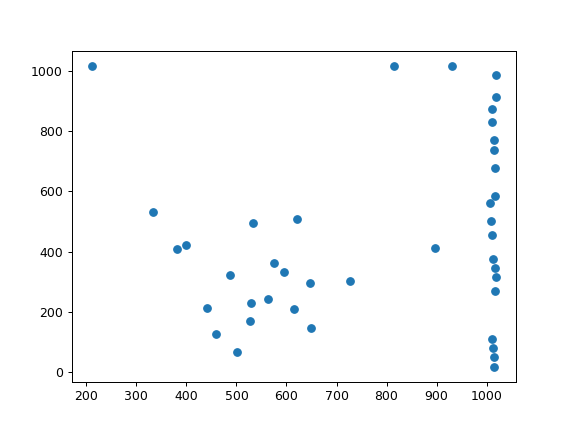

In [245]:
fig, ax = plt.subplots(1)
ax.scatter(peaks[:,0], peaks[:,1])